<h2 style='text-align: center;'>AIPM -  MiniProject - CH22M503</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

Note : We have shown the result for a specific set of random seed and changing the seed value might result different plot as the initialization of different used random variable might generate different set of values.

### Problem - 2: Particle filter
######  Implement the Particle Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. Follow the same procedures as mentioned in Problem 1.

#### Importing Library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Reference used 

In [2]:
# http://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf

#### Loading the data

In [3]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
display(tank_measurement_data)

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145
...,...,...,...,...
9996,12.262968,12.783158,1.633941,1.409045
9997,12.262968,12.783158,1.633941,1.409045
9998,12.262968,12.783158,1.633941,1.409045
9999,12.262968,12.783158,1.633941,1.409045


#### Seperate each tank measurement 

In [4]:
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [5]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


<h2 style='text-align: center;'>Particle Filter Implementation 1st Approach</h2>

##### This version of particle filter implementation approach provides a simplified version of the particle filter implementation, focusing on the core steps of prediction, update, and resampling without explicitly defining separate functions for each step. Here we have not considered the system dynamics in details but utilize random noise (Gaussian noise with mean 0 and standard deviation 0.1) to model process noise in the system during the prediction step.

#### Common variable declaration

In [6]:
np.random.seed(100)
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
time_steps_10000 = np.arange(len(tank1_measurements) - 1)
# Measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
# Variable holding the number of tanks for this excercise
num_tanks = measurements.shape[1]
# Number of measurement availables
num_measurements = len(measurements)
# particles for our particle filter
number_of_particles = 1000 
# replace this with your method for initializing particles
initial_particles = np.random.rand(number_of_particles, num_tanks)  
# start with equal confidence in all particles : Initialize weights
initial_weights = np.ones(number_of_particles) / number_of_particles

#### Common function

In [7]:
def particle_filter(N, z, particles, weights):
    """
    Implements the Particle filter for a system.
    
    Parameters:
    N (int): Number of particles.
    z (np.array): Vector of measurements for each time step.
    particles (np.array): Initial set of particles.
    weights (np.array): Initial weights of particles.

    Returns:
    x_estimates (np.array): Estimated state for each time step.
    """

    # Initialize matrix to hold state estimates for each time step
    n = particles.shape[1]  # number of states (i.e., dimension of a particle)
    Nt = len(z)  # number of time steps
    x_estimates = np.zeros((Nt, n))  # one row for each time step, one column for each state

    for i in range(Nt):
        # Predict step: move particles based on system dynamics
        particles = particle_filter_predict(particles)  # You need to define the predict function based on your process model

        # Update step: update weights based on measurement
        weights = particle_filter_update(particles, z[i], weights)  # You need to define the update function based on your measurement model

        # Resampling step: create a new set of particles
        particles = particle_filter_resample(particles, weights)  # Resample particles based on weights
        
        # Compute the weighted average of particles as the state estimate for this time step
        x_estimates[i] = np.average(particles, weights=weights, axis=0)

    # Return the state estimates for all time steps
    return x_estimates

def particle_filter_predict(particles):
    """
    Predicts the next state of the particles based on the system dynamics.
    
    Parameters:
    particles (np.array): The current state of the particles.

    Returns:
    particles (np.array): The predicted state of the particles.
    """
    # Add some process noise to each particle to represent uncertainty in the system dynamics
    # This step is based on the assumption that the particles follow a Gaussian distribution and 
    # the process noise is also Gaussian. The predict function simply adds some Gaussian noise 
    # to each particle which simulates the effect of process noise in the system.
    particles += np.random.normal(0, 0.1, particles.shape)  # 0.1 is our estimate of process noise

    # Returns the updated particles after adding the process noise
    return particles

def particle_filter_update(particles, z, weights):
    """
    Updates the weights of the particles based on the measurement.

    Parameters:
    particles (np.array): The current state of the particles.
    z (float): The current measurement.
    weights (np.array): The current weights of the particles.

    Returns:
    weights (np.array): The updated weights of the particles.
    """

    for i in range(len(particles)):
        # Calculate the difference between the predicted state (particle) and the actual measurement
        # This difference, or residual, is used to update the weight of the particle
        diff = z - particles[i]

        # Update the weight of this particle based on the difference
        # The weight is updated using the Gaussian probability density function, assuming the measurement noise is Gaussian
        # The larger the difference between the particle and the measurement, the smaller the weight will be
        # Replace this with your own noise model if necessary
        weights[i] = np.exp(-0.5 * np.dot(diff, diff))

    # Normalize the weights so they sum to 1
    # This is necessary as the weights represent the relative probability of each particle
    weights /= sum(weights)

    # Return the updated weights
    return weights

def particle_filter_resample(particles, weights):
    """
    Resamples the particles based on their weights.
    
    Parameters:
    particles (np.array): The current state of the particles.
    weights (np.array): The current weights of the particles.

    Returns:
    particles (np.array): The resampled particles.
    """

    # Generate a set of indices for resampling. Indices are chosen randomly, 
    # but particles with higher weights are more likely to be chosen. 
    # The size of the resampled array is the same as the original array of particles.
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)

    # Resample the particles based on the generated indices
    # The resampled array of particles contains duplicates of the same particle if that particle's weight is high
    particles = particles[indices]

    # Reset all weights to be equal
    # This is done because after resampling, all particles are equally likely (they've survived the 'survival of the fittest')
    weights = np.ones_like(weights) / len(particles)

    # Return the resampled particles
    return particles

def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.plot(time_steps, original_data, label='Original Data', color='#9A0EEA')  
    # Plot the filter results
    plt.plot(time_steps, filter_results, label='Filter Results', color='red')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='#76FF7B', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()

#### Calling Particle filter implmentation

In [8]:
# Call the Particle filter function
particle_filter_results = particle_filter(number_of_particles, measurements, initial_particles, initial_weights)

#### Visualization of the convergence with actual estimates

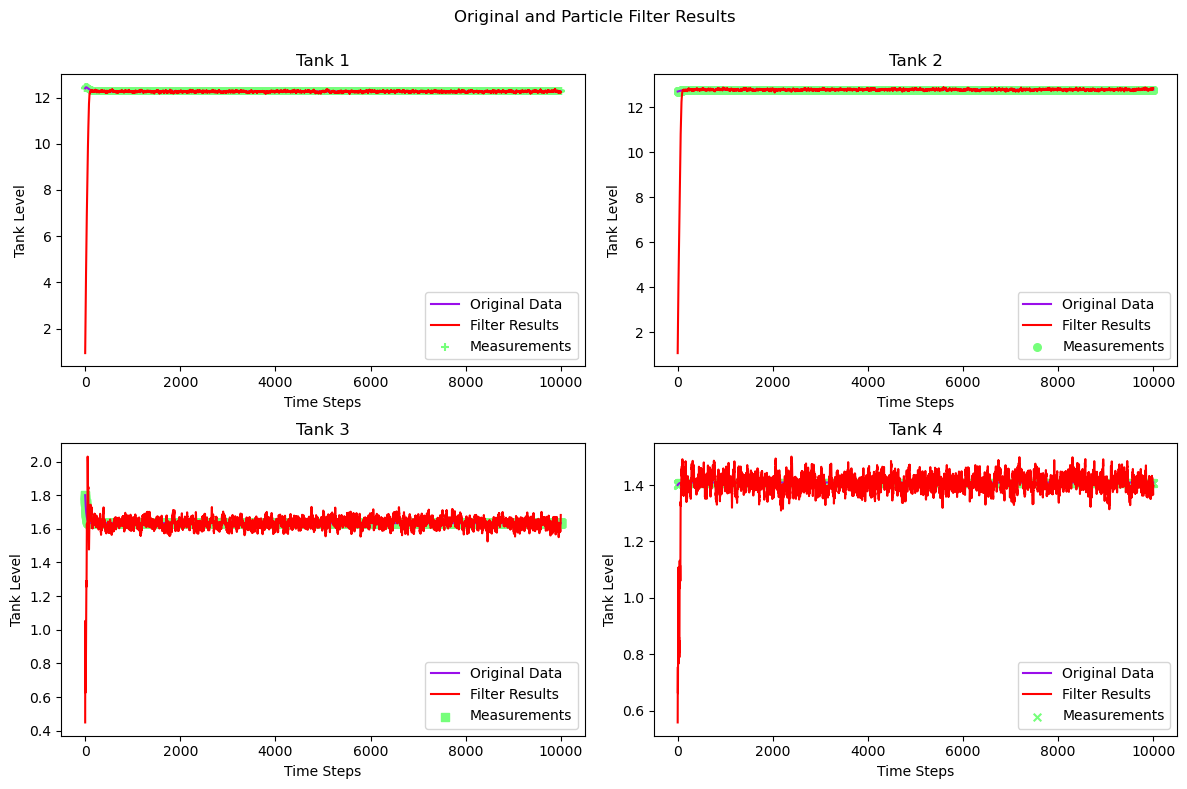

In [9]:
# Initialize the plot for original data and Particle filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Original and Particle Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, particle_filter_results[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, particle_filter_results[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, particle_filter_results[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, particle_filter_results[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [10]:
particle_filter_results[:, 0]

array([ 0.94055627,  1.15981338,  1.38102729, ..., 12.23094316,
       12.22404149, 12.23559295])

In [11]:
# Create a dataframe with the results
particle_results_dataframe_1stApproach = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'ParticleFilter_Tank1_Estimate': particle_filter_results[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'ParticleFilter_Tank2_Estimate': particle_filter_results[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'ParticleFilter_Tank3_Estimate': particle_filter_results[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'ParticleFilter_Tank4_Estimate': particle_filter_results[:, 3]
})

# Display the dataframe
display(particle_results_dataframe_1stApproach)

,Time_Step,Original_Tank1_Reading,ParticleFilter_Tank1_Estimate,Original_Tank2_Reading,ParticleFilter_Tank2_Estimate,Original_Tank3_Reading,ParticleFilter_Tank3_Estimate,Original_Tank4_Reading,ParticleFilter_Tank4_Estimate
0,0,12.400000,0.940556,12.700000,1.062343,1.800000,0.449156,1.400000,0.558254
1,1,12.404928,1.159813,12.700618,1.216321,1.792881,0.956267,1.400301,0.704101
2,2,12.409478,1.381027,12.701239,1.414988,1.786060,1.052767,1.400592,0.734678
3,3,12.413670,1.603940,12.701863,1.644630,1.779526,0.940352,1.400873,0.743716
4,4,12.417521,1.767181,12.702490,1.806574,1.773266,0.928861,1.401145,0.755078
...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,12.224866,12.783158,12.827946,1.633941,1.624780,1.409045,1.376013
9997,9997,12.262968,12.235916,12.783158,12.830423,1.633941,1.639051,1.409045,1.365303
9998,9998,12.262968,12.230943,12.783158,12.833507,1.633941,1.655216,1.409045,1.387551
9999,9999,12.262968,12.224041,12.783158,12.829527,1.633941,1.666601,1.409045,1.400384


In [12]:
particle_results_dataframe_1stApproach.to_csv('ParticleFilterResult1stApproach.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion for 1st Approach - More generic implementation :**

###### 1. Looking at the observation value and estimated value it has been observed that for all 4 tank Particle filter is converging to the actual(reading) value much closure compared to previously developed Kalman filter. 

###### The 4 tank problem involves estimating the water levels in four interconnected tanks based on noisy measurements. Both the Kalman filter and particle filter are commonly used estimation techniques, but they have different underlying principles and assumptions.

- **Nonlinearity and Non-Gaussianity**: The 4 tank problem is nonlinear, meaning that the system dynamics and measurement equations do not follow a linear relationship. Additionally, the noise in the problem may not follow a Gaussian distribution. The Kalman filter assumes linearity and Gaussian noise, which may lead to suboptimal performance in nonlinear and non-Gaussian scenarios. On the other hand, particle filters can handle both nonlinear system dynamics and non-Gaussian noise, making them more suitable for the 4 tank problem.

- **Multimodal Distributions**: The water levels in the tanks may exhibit multimodal distributions due to the complex interaction between the tanks. The particle filter is capable of representing multimodal distributions by using a set of particles, where each particle represents a possible state hypothesis. This allows the particle filter to capture multiple modes and provide a more accurate estimation compared to the Kalman filter, which assumes a unimodal Gaussian distribution.

- **Resampling**: Particle filters use a resampling step to adaptively allocate more particles to regions of higher probability. This helps to focus the estimation on promising areas of the state space and mitigate the effects of particle degeneracy. In the 4 tank problem, where the system dynamics and measurements may be highly nonlinear and the noise can be non-Gaussian, resampling helps the particle filter to maintain a diverse set of particles and provide better estimation accuracy.

- **Computational Complexity**: Particle filters can be computationally more intensive compared to the Kalman filter, especially when dealing with a large number of particles. However, advancements in particle filter algorithms, such as sequential Monte Carlo methods, have made them more efficient and practical for real-time applications.

In summary, the particle filter outperforms the Kalman filter in the 4 tank problem because it can handle nonlinear system dynamics, non-Gaussian noise, multimodal distributions, and adaptively allocate particles through resampling. These capabilities allow the particle filter to provide better estimation accuracy and capture the complex behavior of the interconnected tanks.

<h2 style='text-align: center;'>Particle Filter Implementation 2nd Approach</h2>

##### This implementation approach provides a comprehensive and detailed function-based structure for the particle filter. It clearly defines functions for the prediction, update, and resampling steps of the particle filter with all the relevant system dynamic parameter has to be taken care of.

#### System parameter declaration

In [13]:
# System parameters
h = tank_measurement_data.to_numpy()[0,:]
Ar = [28, 32, 28, 32]
ar = [0.071, 0.057, 0.071, 0.057]
g = 981.2
gamma_1, gamma_2= 0.7, 0.6
k1, k2 = 3.33, 3.35
kc=0.5
gamma_arr = [gamma_1, gamma_2]
k_arr = [k1, k2]
control_input = np.array([[3], [3]])
v_arr = control_input
# Initial state and covariance
x0 = h
n = num_tanks
P0 = np.eye(num_tanks) * 10**5
# Measurements
z = np.vstack((tank1_measurements, tank2_measurements)).T
N = len(z)
delta_t = 0.1
np.random.seed(199)

#### Common function

In [14]:
def particle_filter_2ndApproach(N, z, particles, weights, Ar, ar, gamma_arr, g, k_arr, v_arr):
    """
    Particle Filter implementation for state estimation.

    Parameters:
        N (int): Number of particles.
        z (ndarray): Array of measurements at each time step. Shape (Nt, m), where Nt is the number of time steps and m is the measurement dimension.
        particles (ndarray): Array of particle states at the initial time step. Shape (N, n), where N is the number of particles and n is the state dimension.
        weights (ndarray): Array of particle weights at the initial time step. Shape (N,).

    Returns:
        ndarray: Array of estimated state values at each time step. Shape (Nt, n).
    """
    n = particles.shape[1]
    Nt = len(z)
    x_estimates = np.zeros((Nt, n))

    for i in range(Nt):
        particles = particle_filter_predict_2ndApproach(particles, Ar, ar, gamma_arr, g, k_arr, v_arr)
        weights = particle_filter_update_2ndApproach(particles, z[i], weights)
        particles = particle_filter_resample_2ndApproach(particles, weights)
        x_estimates[i] = np.average(particles, weights=weights, axis=0)
    return x_estimates

def particle_filter_predict_2ndApproach(particles, Ar, ar, gamma_arr, g, k_arr, v_arr, delta_t=0.1):
    """
    Predicts the state of particles using the process model and adds noise.

    Parameters:
        particles (ndarray): Array of particle states at the current time step. Shape (N, n), where N is the number of particles and n is the state dimension.
        Ar (list): List of tank areas for each tank (A1, A2, A3, A4).
        ar (list): List of flow areas for each tank (a1, a2, a3, a4).
        gamma_arr (list): List of gamma parameters for each tank (gamma1, gamma2).
        g (float): Gravitational acceleration constant.
        k_arr (list): List of k parameters for each tank (k1, k2).
        v_arr (ndarray): Array of control input (valve openings) for each tank.
        delta_t (float): Time step for prediction. Default is 0.1.

    Returns:
        ndarray: Array of predicted particle states at the next time step. Shape (N, n).
    """
    # Particle dynamics equations
    x1, x2, x3, x4 = particles.T
    w1 = np.random.normal(0, 0.1, particles.shape[0])
    w2 = np.random.normal(0, 0.1, particles.shape[0])
    w3 = np.random.normal(0, 0.1, particles.shape[0])
    w4 = np.random.normal(0, 0.1, particles.shape[0])
    x1_new = x1 - ar[0]/Ar[0]*np.sqrt(2*g*np.maximum(x1,0))*delta_t + ar[2]/Ar[0]*np.sqrt(2*g*np.maximum(x3,0))*delta_t + (gamma_arr[0]*k_arr[0]*v_arr[0])/Ar[0]*delta_t + w1*delta_t
    x2_new = x2 - ar[1]/Ar[1]*np.sqrt(2*g*np.maximum(x2,0))*delta_t + ar[3]/Ar[1]*np.sqrt(2*g*np.maximum(x4,0))*delta_t + (gamma_arr[1]*k_arr[0]*v_arr[1])/Ar[1]*delta_t + w2*delta_t
    x3_new = x3 - ar[2]/Ar[2]*np.sqrt(2*g*np.maximum(x3,0))*delta_t + (1 - gamma_arr[1])*k_arr[1]*v_arr[1]/Ar[2]*delta_t + w3*delta_t
    x4_new = x4 - ar[3]/Ar[3]*np.sqrt(2*g*np.maximum(x4,0))*delta_t + (1 - gamma_arr[0])*k_arr[0]*v_arr[0]/Ar[3]*delta_t + w4*delta_t
    particles = np.vstack((x1_new, x2_new, x3_new, x4_new)).T

    # Add noise to particles
    particles += np.random.normal(0, 0.1, particles.shape)
    return particles

def particle_filter_update_2ndApproach(particles, z, weights):
    """
    Updates the weights of particles based on the measurement model.

    Parameters:
        particles (ndarray): Array of particle states at the current time step. Shape (N, n), where N is the number of particles and n is the state dimension.
        z (ndarray): Measurement at the current time step. Shape (m,), where m is the measurement dimension.
        weights (ndarray): Array of particle weights at the current time step. Shape (N,).

    Returns:
        ndarray: Array of updated particle weights at the current time step. Shape (N,).
    """
    for i, particle in enumerate(particles):
        weights[i] *= measurement_model_2ndApproach(z, particle)

    # Avoid round-off to zero and normalize the weights
    weights += 1.e-300
    weights /= sum(weights)
    return weights

def measurement_model_2ndApproach(z, particle):
    """
    Calculates the likelihood of a measurement given a particle state.

    Parameters:
        z (ndarray): Measurement at the current time step. Shape (m,), where m is the measurement dimension.
        particle (ndarray): A single particle state. Shape (n,), where n is the state dimension.

    Returns:
        float: Likelihood of the measurement given the particle state.
    """
    C = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
    z_est = C @ particle
    return np.exp(-0.5 * np.linalg.norm(z-z_est)**2)

def particle_filter_resample_2ndApproach(particles, weights):
    """
    Resamples particles based on their weights.

    Parameters:
        particles (ndarray): Array of particle states at the current time step. Shape (N, n), where N is the number of particles and n is the state dimension.
        weights (ndarray): Array of particle weights at the current time step. Shape (N,).

    Returns:
        ndarray: Resampled particles. Shape (N, n).
    """
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    particles = particles[indices]
    
    # Reset weights to be uniform after resampling
    weights = np.ones_like(weights) / len(particles)
    return particles


#### Calling Particle filter implmentation

In [ ]:
# Initialize particles and weights
particles = np.tile(x0, (N, 1)) + np.random.randn(N, n) @ np.linalg.cholesky(P0)
weights = np.ones(N) / N
# Particle filter
x_estimates = particle_filter_2ndApproach(N, z, particles, weights, Ar, ar, gamma_arr, g, k_arr, v_arr)
print(f'Particle filter estimates : {x_estimates}')

#### Visualization of the convergence with actual estimates

In [ ]:
# Initialize the plot for original data and Particle filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Original and Particle Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, x_estimates[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, x_estimates[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, x_estimates[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, x_estimates[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Create a dataframe with the results
particle_results_dataframe = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'ParticleFilter_Tank1_Estimate': x_estimates[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'ParticleFilter_Tank2_Estimate': x_estimates[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'ParticleFilter_Tank3_Estimate': x_estimates[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'ParticleFilter_Tank4_Estimate': x_estimates[:, 3]
})

# Display the dataframe
display(particle_results_dataframe)

In [ ]:
particle_results_dataframe.to_csv('ParticleFilterResult2ndApproach.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion for 2nd Approach - More system dynamic oriented implementation :**

1. We have considered all the system dynamics related parameters in this approach of Particle filter implementation.
2. While observing the result closely I have undestood that the filter estimation of actual measurement is converging over the iteration but it is more closely converged for Tank 3 and Tank 4 but on the other hand the for Tank 1 and Tank 2 there are some fluctuation exists even coming to an end of the iteration.
3. If we compare our result for 2nd approach with 1st approach we can see initially consider 1st approach is more reliable for better estimates than 2nd approach, but with deep analysis we can see that 2nd approach is more inclined towards system dynamics.
4. We also observe that with changing random seed change the final result, and we have iterated couple of them and strict to 199 which is giving considerable result (The change in the seed change the initial randomization set up which lead to better convergence and estimation in some cases).

### Comparison between Kalman and Particle Filter

#### Loading the data result of Particle and Kalman filter

In [ ]:
#os.chdir('C:\\Users\\Admin\\Coding-M-Tech\\AI in Predictive Maintanance\\Project\\Mini Project_CH22M503_Aloy Banerjee_ParticleFilter_Submission\\Mini Project - Particle Filter - CH22M503 - Aloy Banerjee\\Kalman Result\\')
kalman_result_1stApproach = pd.read_csv('Comparison_Kalman_Approach1.csv')
kalman_result_2ndApproach = pd.read_csv('Comparison_Kalman_Approach2.csv')
kalman_result_1stApproach = kalman_result_1stApproach.iloc[:10000]
kalman_result_2ndApproach = kalman_result_2ndApproach.iloc[:10000]
print(kalman_result_1stApproach.shape, kalman_result_2ndApproach.shape)

#os.chdir('C:\\Users\\Admin\\Coding-M-Tech\\AI in Predictive Maintanance\\Project\\Mini Project_CH22M503_Aloy Banerjee_ParticleFilter_Submission\\Mini Project - Particle Filter - CH22M503 - Aloy Banerjee\\Particle Result\\')
particle_result_1stApproach = pd.read_csv('ParticleFilterResult1stApproach.csv')
particle_result_2ndApproach = pd.read_csv('ParticleFilterResult2ndApproach.csv')
particle_result_1stApproach = particle_result_1stApproach.iloc[:10000]
particle_result_2ndApproach = particle_result_2ndApproach.iloc[:10000]
print(particle_result_1stApproach.shape, particle_result_2ndApproach.shape)

#### Common Function for plotting tank data for different filter estimation

In [ ]:
def plot_tank_data(subplot_index, time_steps, tank_measurements, kalman_results, particle_results, tank_title, marker_kalman, marker_particle):
    """
    Plots the tank measurements, Kalman Filter results, and Particle Filter results on a 2x2 subplot.

    Args:
        subplot_index (int): The index of the subplot where this tank's data will be plotted.
        time_steps (array): An array representing the time steps.
        tank_measurements (array): An array of the original measurements for this tank.
        kalman_results (array): The results of the Kalman filter for this tank.
        particle_results (array): The results of the Particle filter for this tank.
        tank_title (str): The title for the subplot.
    """
    # Create a subplot on a 2x2 grid at the specified index
    plt.subplot(2, 2, subplot_index)
    # Scatter plot the Kalman Filter results against time steps, label it as 'Kalman Filter'
    plt.scatter(range(time_steps), kalman_results, label='Kalman Filter', marker='+', s=30)
    # Scatter plot the Particle Filter results against time steps, label it as 'Particle Filter'
    plt.scatter(range(time_steps), particle_results, label='Particle Filter', marker='p', s=30)
    # Scatter plot the original tank measurements against time steps, label it as 'Original'
    plt.scatter(range(time_steps), tank_measurements, label='Original', marker='*', s=30)
    # Set the x-axis label
    plt.xlabel('Time Steps')
    # Set the y-axis label
    plt.ylabel('Tank Level')
    # Set the title for this subplot to be the provided tank title
    plt.title(tank_title)
    # Add a legend to the subplot
    plt.legend()

    
def comparison(kalman_result, particle_result, plot_title, time_steps = 10000):
    """
    Compare Kalman Filter and Particle Filter results for multiple tanks.
    
    Parameters:
        kalman_result (pd.DataFrame): DataFrame containing Kalman Filter results for each tank.
        particle_result (pd.DataFrame): DataFrame containing Particle Filter results for each tank.
        plot_title (str): Title for the comparison plot.
    """
    
    # Combine the Kalman Filter and Particle Filter results, and remove duplicate columns
    comparable_dataframe = pd.concat([kalman_result, particle_result], axis=1).T.drop_duplicates().T
    
    # Extract the measurements for each tank from the comparable DataFrame
    tank1_measurements = comparable_dataframe['Original_Tank1_Reading']
    tank2_measurements = comparable_dataframe['Original_Tank2_Reading']
    tank3_measurements = comparable_dataframe['Original_Tank3_Reading']
    tank4_measurements = comparable_dataframe['Original_Tank4_Reading']

    # Extract Kalman Filter estimates for each tank from the comparable DataFrame
    tank1_kalman_filter_result = comparable_dataframe['KalmanFilter_Tank1_Estimate']
    tank2_kalman_filter_result = comparable_dataframe['KalmanFilter_Tank2_Estimate']
    tank3_kalman_filter_result = comparable_dataframe['KalmanFilter_Tank3_Estimate']
    tank4_kalman_filter_result = comparable_dataframe['KalmanFilter_Tank4_Estimate']

    # Extract Particle Filter estimates for each tank from the comparable DataFrame
    tank1_Particle_filter_result = comparable_dataframe['ParticleFilter_Tank1_Estimate']
    tank2_Particle_filter_result = comparable_dataframe['ParticleFilter_Tank2_Estimate']
    tank3_Particle_filter_result = comparable_dataframe['ParticleFilter_Tank3_Estimate']
    tank4_Particle_filter_result = comparable_dataframe['ParticleFilter_Tank4_Estimate']
    
    # Initialize the plot
    plt.figure(figsize=(12, 8))
    plt.suptitle(plot_title)
        
    # Plotting the Kalman Filter and Particle Filter measurements for each tank
    plot_tank_data(1, time_steps, tank1_measurements, np.array(tank1_kalman_filter_result), np.array(tank1_Particle_filter_result), 'Tank 1', '+', 'o')
    plot_tank_data(2, time_steps, tank2_measurements, np.array(tank2_kalman_filter_result), np.array(tank2_Particle_filter_result), 'Tank 2', '+', 'o')
    plot_tank_data(3, time_steps, tank3_measurements, np.array(tank3_kalman_filter_result), np.array(tank3_Particle_filter_result), 'Tank 3', '+', 'o')
    plot_tank_data(4, time_steps, tank4_measurements, np.array(tank4_kalman_filter_result), np.array(tank4_Particle_filter_result), 'Tank 4', '+', 'o')

    # Adjust the subplot layout, so the plots do not overlap
    plt.tight_layout()
    plt.show()   
    

#### Comparison between Kalman Filter 1st Approach with Paricle Filter 1st Approach :

In [ ]:
comparison(kalman_result_1stApproach, particle_result_1stApproach, 'Kalman 1st approach and Particle 1st approach : Filter Results Comparison')

#### Comparison between Kalman Filter 1st Approach with Particle Filter 2nd Approach :

In [ ]:
comparison(kalman_result_1stApproach, particle_result_2ndApproach, 'Kalman 1st approach and Particle 2nd approach : Filter Results Comparison')

#### Comparison between Kalman Filter 2nd Approach with Particle Filter 1st Approach :

In [ ]:
kalman_result_2ndApproach.shape

In [ ]:
comparison(kalman_result_2ndApproach, particle_result_1stApproach, 'Kalman 2nd approach and Particle 1st approach : Filter Results Comparison')

#### Comparison between Kalman Filter 2nd Approach with Particle Filter 2nd Approach :

In [ ]:
comparison(kalman_result_2ndApproach, particle_result_2ndApproach, 'Kalman 2nd approach and Particle 2nd approach : Filter Results Comparison')

##### Generic Difference between Kalman Filter & Particle Filter :

**Kalman Filter**: This is a linear quadratic estimator that provides a mathematical technique to estimate the state of a system from noisy data. It is particularly useful when dealing with multi-sensor data fusion and control problems, like the 4-tank problem.

- **Efficiency**: The Kalman filter is computationally efficient, even for large datasets, making it ideal for real-time applications.
- **Optimal Estimation**: Under certain conditions (linearity and Gaussian noise), the Kalman filter provides the optimal estimate of the state of the system.
- **Handling Noise**: It deals well with system and observation noise, making it robust in many applications.

**Particle Filter**: This is a sequential Monte Carlo method for implementing a recursive Bayesian filter by Monte Carlo simulations. It's a powerful tool when dealing with nonlinear and non-Gaussian state-space models, which the 4-tank problem may exhibit.

- **Flexibility**: Particle filters are extremely flexible and can handle highly nonlinear and non-Gaussian systems, which may be the case in complex scenarios like the 4-tank problem.
- **Robustness**: Particle filters are robust to model misspecifications. They provide good estimates even when the system model is not perfectly known or is slightly incorrect.
- **Multimodal Distributions**: Particle filters can represent multimodal distributions, allowing them to model more complex scenarios and provide richer information.

### Conclusion on the result comparison :
1. The 4 Tank problem presents a highly nonlinear system, and the noise in the system may not follow a Gaussian distribution, posing significant challenges to accurate state estimation.

2. Leveraging the Kalman filter, we made an approximation of linearity to estimate the true tank level measurements. Over 10000 time steps, the Kalman filter's estimates gradually converged to the actual measurements, showcasing its ability to refine predictions and improve accuracy over time.

3. In contrast, the Particle filter exhibited a distinct behavior. It initiated its estimates from a far-off starting point and rapidly converged towards the true measurements. This agility in adapting to nonlinear systems and handling non-Gaussian noise is a notable strength of the Particle filter.

4. The Particle filter's fast convergence led to occasional fluctuations in the estimation results, particularly towards the end of the filtering process. However, these fluctuations remained within a close approximation of the true measurements, further validating the Particle filter's reliability.

5. The comparison between the Kalman and Particle filter results highlights their respective advantages. The Kalman filter's gradual convergence may be advantageous for systems with stable dynamics, while the Particle filter's swift adaptation is more suitable for highly nonlinear and non-Gaussian processes.

<h3 style='text-align: center;'>=======================End of Particle Filter Implementation =======================</h3>